## Practica 03: Projecció prespectiva + Calibratge Càmera

In [378]:
import numpy as np    
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

path_calib = ['Imatges/Calibracio/'+ x for x in os.listdir('Imatges/Calibracio')]
path_cas1 = ['Imatges/Cas1/' + x for x in os.listdir('Imatges/Cas1')]
path_cas2 = ['Imatges/Cas2/' + x for x in os.listdir('Imatges/Cas2')]

In [379]:
def find_chess_board(img, squares = (10,7)):
    retval, corners = cv2.findChessboardCorners(img, squares, flags = cv2.CALIB_CB_NORMALIZE_IMAGE)
    if not retval:
        raise Exception('Corners no trobats')
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners2 = cv2.cornerSubPix(img,corners, (11,11), (-1,-1), criteria)
    im = cv2.drawChessboardCorners(img, squares, corners2, retval)
    return corners2, im


def real_coords(corners,  squares = (10,7)):
    x_p = [(30*9*0.75) + 30 * n for n in range(squares[0])]
    y_p = [(30*6*0.75) + 30 * n for n in range(squares[1])]
    m = np.zeros((corners.shape[0],  3))
    c = 0
    for y in y_p:
        for x in x_p:
            m[c] = np.array([x,y,0])
            c+=1
    return m.astype(np.float32)

def homography_matrix(corners, squares = (10,7)):

    ## Estructura per taula amb les característiques del enunciat
    m = real_coords(corners)
    h ,status = cv2.findHomography(corners,m)

    return h

def ms_hoography_matrix(corners, squares):
    
    m = real_coords(corners)[:,:2]
 
    A = np.array([(xs, ys, 1, 0, 0 , 0, -xd*xs, -xd*ys, -xd) if (c%2 == 0) else (0, 0, 0, xs, ys , 1, -yd*xs, -yd*ys, -yd)\
        for c, ((xs,ys),(xd,yd)) in enumerate([(a[0],b) for a,b in zip(corners2, m)])])

    V, S, C = np.linalg.svd(A)

    H = (C[-1,:]/C[-1,-1]).reshape(3,3)

    return H

def prespecitve(h, img):
    return cv2.warpPerspective(img, h, (675,450))  


def read_gray(path):
    pattern = cv2.imread(path)
    pattern_gray =  cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)
    return pattern_gray

def plot_org_top(im1,im2):
    fig, (ax0, ax1) = plt.subplots(1,2, figsize = (20,20))
    ax0.title.set_text('Original')
    ax0.imshow(im1, cmap = 'gray')
    ax1.title.set_text('cv2 homography')
    ax1.imshow(im2, cmap = 'gray')

def canny_filter(img):
    low_threshold = 100
    high_threshold = 120
    edges = cv2.Canny(img, low_threshold, high_threshold)
    return edges

def find_coin(imgc):

    img = cv2.cvtColor(imgc, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(img, 25)
    minDist = img.shape[0]/12
    param1 = 100 #500
    param2 = 30 #200 #smaller value-> more false circles
    minRadius = 5
    maxRadius = 1000 #10

    # docstring of HoughCircles: HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) -> circles
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    c = 0
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            cv2.circle(imgc, (i[0], i[1]), i[2], (0, 255, 0), 2)
            c+=1
    else:
        print('No circles found')
    
    print(f'{c} circles were found')
    return imgc, circles
    # Show result for testing

### 1: Detecció i Caracterització de les peces circulars

#### Cas 1

In [380]:
patro1 = cv2.imread(path_cas1[0])
patro1_gray = read_gray(path_cas1[0])
img1 = read_gray(path_cas1[1])
imgc1 = cv2.imread(path_cas1[1])

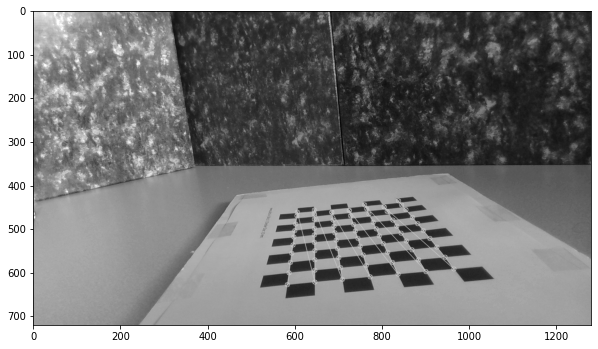

In [381]:
corners1, im1 = find_chess_board(patro1_gray, (10,7))
plt.figure(figsize = (10,10))
plt.imshow(im1, cmap = 'gray')

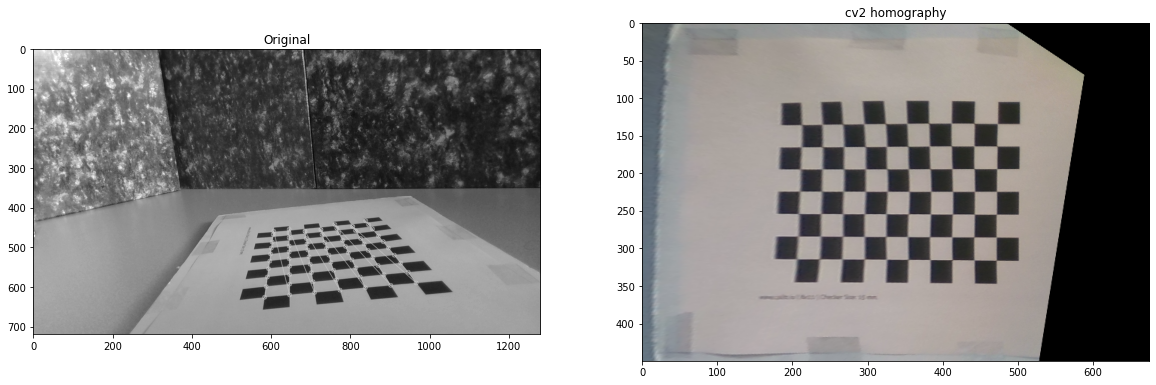

In [382]:
h1 = homography_matrix(corners1, (10,7))
top1 = prespecitve(h1, patro1)
plot_org_top(patro1_gray, top1)

In [383]:
h1

array([[-3.94665459e-01, -3.44425114e+00,  1.62022177e+03],
       [ 6.55305073e-01, -1.08693005e+00, -2.17798861e+02],
       [-4.86067939e-04, -3.75086378e-03,  1.00000000e+00]])

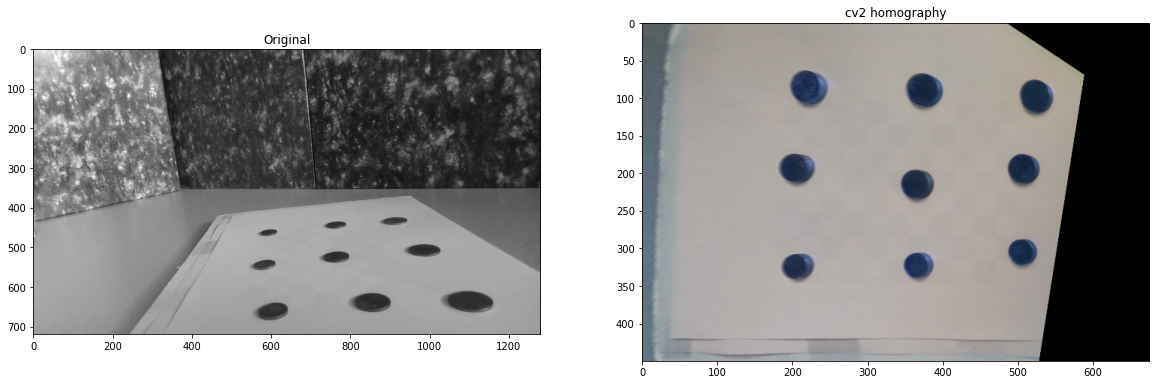

In [384]:
top_coin1 = prespecitve(h1, imgc1)
plot_org_top(img1, top_coin1)

In [385]:
i1, c1 = find_coin(top_coin1)

9 circles were found


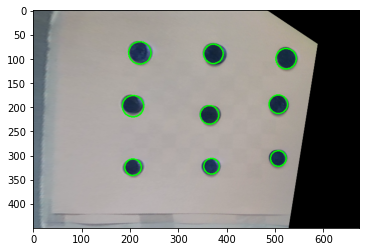

In [386]:
plt.imshow(i1)

#### Cas 2

In [387]:
patro2 = cv2.imread(path_cas2[0])
patro2_gray = read_gray(path_cas2[0])
img2 = read_gray(path_cas2[1])
imgc2 = cv2.imread(path_cas2[1])

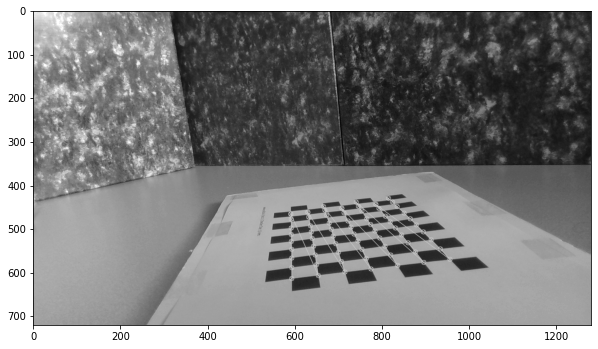

In [388]:
corners2, im2 = find_chess_board(patro2_gray, (10,7))
plt.figure(figsize = (10,10))
plt.imshow(im2, cmap = 'gray')

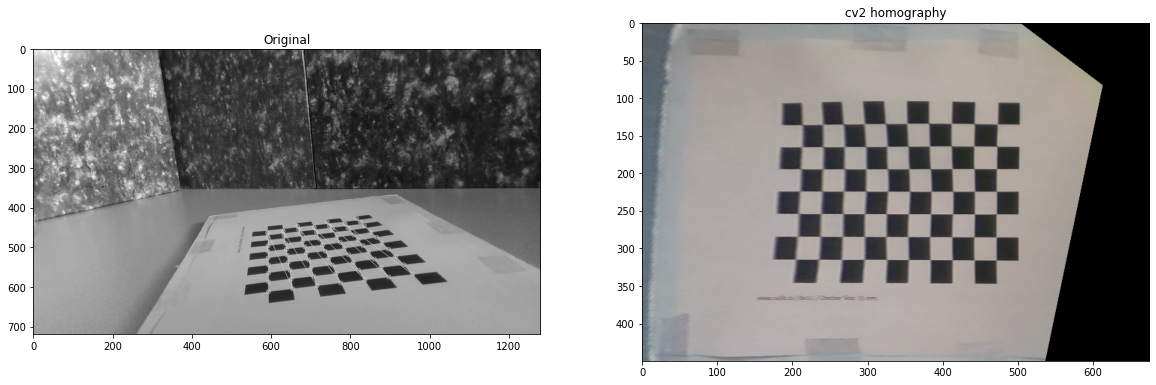

In [389]:
h2 = homography_matrix(corners2, (10,7))
top2 = prespecitve(h2, patro2)
plot_org_top(patro2_gray, top2)

In [390]:
h2

array([[-4.42829950e-01, -3.36248331e+00,  1.60854951e+03],
       [ 6.07751976e-01, -1.16372579e+00, -1.27883257e+02],
       [-5.02284890e-04, -3.62561134e-03,  1.00000000e+00]])

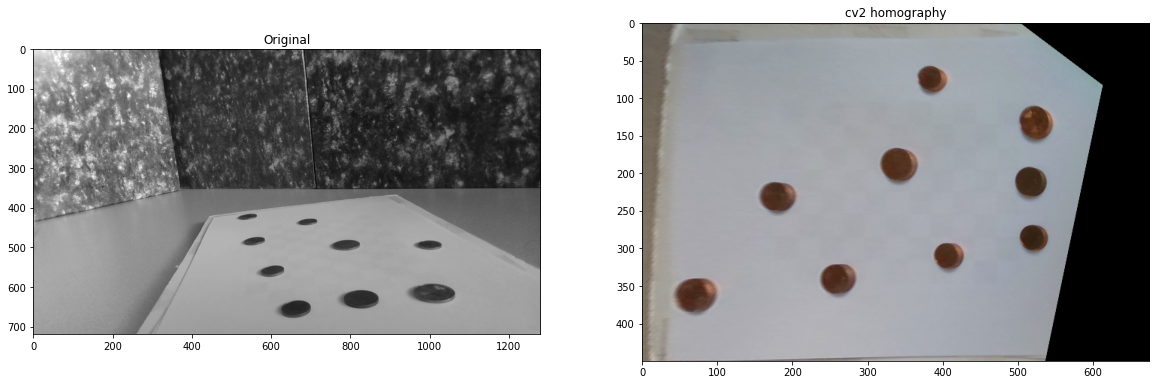

In [391]:
top_coin2 = prespecitve(h2, imgc2[:,:,::-1])
plot_org_top(img2, top_coin2)

In [392]:
i2, c2 = find_coin(top_coin2)

9 circles were found


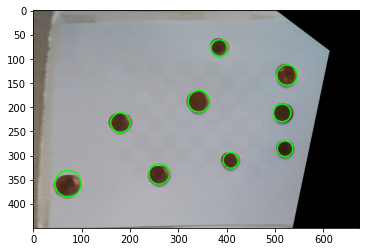

In [393]:
plt.imshow(i2)

## 2: Calibratge de la càmera

In [394]:

def calibration_points(path,  squares = (10,7)):
   

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    cf = 0
    cfn = 0
    
    objp = np.zeros((10*7,3), np.float32)
    objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)
    
    for image in path:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        try:
            corners, im = find_chess_board(gray, squares)
            corners = corners.reshape((corners.shape[0], corners.shape[2])).astype(np.float32)
            # objp = real_coords(corners)

            objpoints.append(objp)
            imgpoints.append(corners)
            cf += 1
            
        except Exception:
            cfn += 1

    
    print(f'{len(path)} images where used for calibration: in {cf} images the chessboard was found and in {cfn} image(s) the chess board was not found and omitted.')
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        w = imgpoints2.shape
        error = cv2.norm(imgpoints[i].astype(np.float32), imgpoints2.reshape((w[0], w[2])).astype(np.float32), cv2.NORM_L2)/len(imgpoints2)
        mean_error += error
    print( "Total error: {}".format(mean_error/len(objpoints)) )
    return ret, mtx, dist, rvecs, tvecs

def undistort_image(img, mtx, dist):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst

In [395]:
ret, mtx, dist, rvecs, tvecs = calibration_points(path_calib, (10,7))

22 images where used for calibration: in 17 images the chessboard was found and in 5 image(s) the chess board was not found and omitted.
Total error: 0.05871332473966707


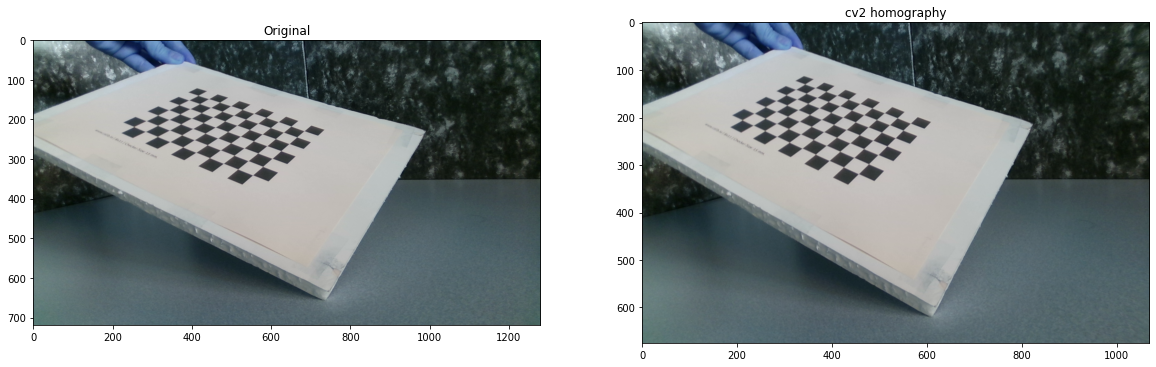

In [396]:
img = cv2.imread(path_calib[1])
i = undistort_image(img, mtx, dist)
plot_org_top(img, i)

## 3 Mostrar classificació de les peces amb realitat augmentada

In [397]:
def draw_axis(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, tuple(map(np.uint32, corner)), tuple(map(np.uint32, imgpts[0].ravel())), (255,0,0), 5)
    img = cv2.line(img, tuple(map(np.uint32,corner)), tuple(map(np.uint32, imgpts[1].ravel())), (0,255,0), 5)
    img = cv2.line(img, tuple(map(np.uint32,corner)), tuple(map(np.uint32, imgpts[2].ravel())), (0,0,255), 5)
    return img


def solve_pnp(img,  mtx, dist, squares = (10,7)):

    axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    objp = np.zeros((10*7,3), np.float32)
    objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)
    
    try:
        corners, im = find_chess_board(gray, squares)
        corners = corners.reshape((corners.shape[0], corners.shape[2])).astype(np.float32)
        ret,rvecs, tvecs = cv2.solvePnP(objp, corners, mtx, dist)
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        print(imgpts)
        img = draw_axis(img,corners,imgpts)
        
    except Exception:
        print('chessboard not found')
    
    return img


def draw_radious(img, circles, imgpts):

    # circle = circles[0][0]
    for circle in circles[0]:
        if circle[3] == 2: colour = (255,0,0)
        elif circle[3] == 1: colour = (0,255,0)
        elif circle[3] == 0: colour = (0,0,255)

        img = cv2.line(img, tuple(map(np.uint32, circle[0:2])), tuple(map(np.uint32, imgpts[0].ravel())), (255,0,0), 5)
        img = cv2.line(img, tuple(map(np.uint32,circle[0:2])), tuple(map(np.uint32, imgpts[1].ravel())), (0,255,0), 5)
        img = cv2.line(img, tuple(map(np.uint32,circle[0:2])), tuple(map(np.uint32, imgpts[2].ravel())), (0,0,255), 5)
    return img

def circles_pnp(img,cercles, mtx,dist):


    centers = cercles[0,:,:2].astype(np.float32)
    axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)
    objp = np.array([centers[:,0],centers[:,1],[0]*len(centers)], dtype = np.float32).T
    ret,rvecs, tvecs = cv2.solvePnP(objp , centers, mtx, dist)
    imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
    print(imgpts)
    img = draw_radious(img,cercles,imgpts)
    return img


### Axis plot

[[[498.88806 169.41228]]

 [[342.74442 178.76196]]

 [[404.9841   38.51619]]]


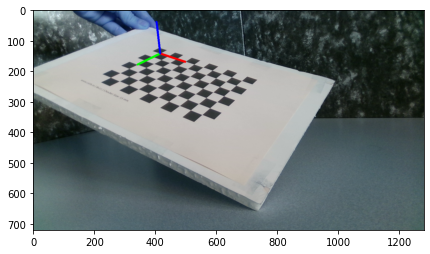

In [398]:
img = cv2.imread(path_calib[1])
i = solve_pnp(img, mtx, dist, (10,7))
f = plt.figure(figsize=(7,7))
plt.imshow(i)

### Coin plot

 Classifiquem els centres dels cercles trobats en l'exercici 1 i representem els centres en l imatge original

In [399]:
def classify_circle(circles):
    size = np.array([x[2] for x in circles[0]]).reshape(-1,1)**2
    kmeans = KMeans(n_clusters=3, random_state=0).fit(size)
    clas = kmeans.labels_
    return np.array([np.append(x,y) for x,y in zip(circles[0], clas)]).reshape(1, 9, 4)


def reperspective_center(h, centers):
    inv = np.linalg.inv(h)
    dest = np.zeros_like(centers)
    c = 0
    print(len(centers[0]))
    for center in centers[0]:
        point = np.array([center[0],center[1], 1]) @ inv.T
        point = [point[0]/point[2], point[1]/point[2]]
        dest[0][c] = [*point, *centers[0][c,2:]]
        c += 1
    return dest

def draw_points(img, pts):
    pts = pts[0][:,:2]
    for point in pts:
        cv2.line(img, point, (point[0]+1,point[1]+1), (0,255,0),10)

    return img


### Cas 1

9


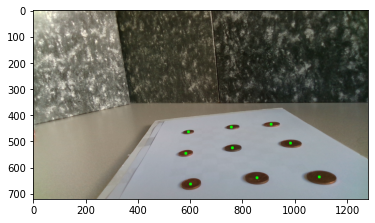

In [400]:
cC1 = classify_circle(c1)
hom1 = reperspective_center(h1, cC1)
m = draw_points(imgc1, hom1)
plt.imshow(m[:,:,::-1])

[[[21.97929  14.786137]]

 [[19.418686 17.857077]]

 [[18.36955  14.450079]]]


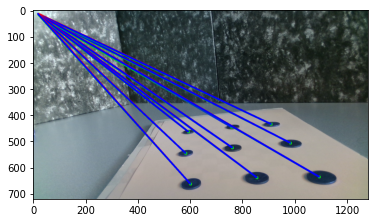

In [401]:
u = circles_pnp(imgc1, hom1, mtx, dist)
plt.imshow(u)

### Cas 2

9


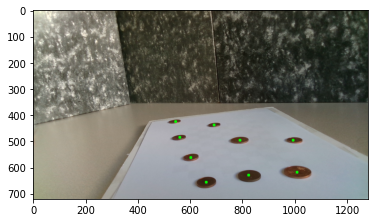

In [402]:
cC2 = classify_circle(c2)
hom2 = reperspective_center(h2, cC2)
k = draw_points(imgc2, hom2)
plt.imshow(k[:,:,::-1])